Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [71]:
NAME = ""
COLLABORATORS = ""

---

# **Practice 12: Solving PDEs with finite differences**

## Practice guide

In this second graded practice you have to solve the exercises below. The codes you need to solve this problems are similar, but not the same, to some of the codes from the regular practices.

You will have to handle a notebook with:

* The working programs that solve the exercises. I will run all the codes.
* An explanation of the methods you are using.
* An explanation of your procedure to calculate the solutions.
* An explanation of the results.

## 1- Temperature around a radiactive rod

Let us suppose that we want to calculate the change in temperature around a radiactive rod buried on the ground. The temperature $T$ fulfills the following equation in polar coordinates:

$$\frac{1}{\kappa}\frac{\partial T}{\partial t}-\frac{\partial^2 T}{\partial r^2}-\frac{1}{r}\frac{\partial T}{\partial r} = S(r, t)$$

where the source term due to the radioactive decay of rod is given by:

$$ S(r, t) = \left\{\begin{array}{l}
T_{rod}e^{−t/\tau_0} /a^2 \quad \textrm{for}\; r \leq a \\
0 \qquad \qquad \quad \textrm{elsewhere}.
\end{array}\right.$$

where the radius of the rod is $a = 25\;cm$, the diffusion coefficient is $\kappa = 2 \cdot 10^7 \;cm^2/year$, the rod's temperature is  $T_{rod} = 1K$, final time $\tau_0 = 100\; years$, the radius of the domain where we want to solve the equation is $r_c = 100\;cm$, the environment's temperature is $T_E = 300\;K$, $0 < r < r_c$ and $0 < t < \tau_0$. Initially $T(r, t = 0) = 3$.

This is complemented with the boundary conditions

$$ \frac{\partial T}{\partial r}(r = 0, t) = 0 \; \textrm{ and } \; T(r = r_c, t) = 300K$$

**Exercises:** 

1. Solve this equation using a finite differences method.


## 2- Wave equation

This is the wave equation with the corresponding initial conditions and periodic boundary conditions

$$\begin{array}{l}
u_{tt}=u_{xx} \\
u(x,0) = \sin{(4\pi x)} \\
u_t(x,0)=0 \\
u(0,t)=u(1,t)
\end{array} $$



**Exercises:**

1. Solve the equation using finite differences.
2. Solve the equation up to time $t=100$ with different time-steps $\Delta t$ bigger, equal and smaller than the $\Delta x$. Explain the results.

# Solution

### Imports

In [72]:
import numpy as np
from typing import Callable, Tuple

import matplotlib.pyplot as plt
from matplotlib.animation import  FuncAnimation

## Question 1

## Utilmethods

In [ ]:
def __tridiag(v1: float, v2: float, v3: float, N: int, k1: int = -1, k2: int = 0, k3: int = 1) -> np.ndarray:
    return np.diag(np.full(N-abs(k1), v1), k1) + np.diag(np.full(N-abs(k2), v2), k2) + np.diag(np.full(N-abs(k3), v3), k3)


def explicit_parabollic(h: float, k: float, K: float, tau0: float, a: float,
                        r0: float, rf: float, t0: float, tf: float, u_t0: Callable, u_rf: Callable, u_devr0: Callable) -> Tuple[np.ndarray]:
    r'''Computes, explicitly, a parabollic PDE of the kind:
    :math: `$$\begin{array}{l}
                \frac{du}{dt} = \frac{d^2u}{dt^2} \\
                u(r0,t) = u(rf,t) = 0 \\
                u(x,t0) = u0
                \end{array}$$`

    over the interval :math: `$[t0,tf]$` for a stepsize `h` in x and `k` in t,
    with forward finite differences.

    Note that the coefficient (`$1-2*k/h$`) should be nonnegative, otherwise
    the errors will be magnified.

    Args:
        h (float): Step size in x.
        k (float): Step size in t.
        r0 (float): Initial position.
        rf (float): Final position.
        t0 (float): Initial time.
        tf (float): Final time.
        u0 (function): Function of x in t0. u(x, t0).

    Returns:
        Tuple[np.ndarray]: Solution of the PDE in those intervals, x mesh, t mesh.
    '''
    s = k/h**2

    x = np.arange(r0, rf+h, h)
    t = np.arange(t0, tf+h, h)

    LEN_X = len(x)
    LEN_T = len(t)

    v1 = v3 = s
    v2 = 1 - 2*s

    m = __tridiag(v1, v2, v3, LEN_X)

    sol = np.zeros((LEN_X, LEN_T))
    sol[:, 0] = u0(x)
    sol[0, 0] = sol[-1, 0] = 0

    for ti in range(1, LEN_T):
        sol[:, ti] = m @ sol[:, ti-1]

    return sol, x, t


## Question 2

### Utilmethods

In [73]:

def run_animation(dt, x, y):

    fig = plt.figure()
    ax = plt.axes(xlim=(-0.2, 1.2), ylim=(-0.025, 0.025))
    line, = ax.plot([], [])

    def init():
        line.set_data([], [])
        return line,

    def animate(i, *fargs):
        line.set_data(fargs[0], fargs[1][:, i])
        return line,

    return FuncAnimation(fig, animate, fargs=[x, y], init_func=init, frames=len(x), interval=20, blit=True)
    


def hyperbolic(h: float, k: float, x0: float, xf: float, t0: float, tf: float, u0: Callable) -> Tuple[np.ndarray]:
    r'''Computes, a hyperbolic PDE of the kind:
    :math: `$$\begin{array}{l}
                U_{tt}=U_{xx} \\
                U(x0,t)=U(xf,t)=0 \; \textrm{ and } \; \frac{\partial U}{\partial t}(x, t0)=0 \\
                U(x,t0)=u0(x) \\
                \end{array}$$`

    over the interval :math: `$[t0,tf]$` for a stepsize `h` in x and `k` in t.

    Args:
        h (float): Step size in x.
        k (float): Step size in t.
        x0 (float): Initial position.
        xf (float): Final position.
        t0 (float): Initial time.
        tf (float): Final time.
        u0 (function): Function of x in t0. u(x, t0).

    Returns:
        Tuple[np.ndarray]: Solution of the PDE in those intervals, x mesh, t mesh.
    '''
    rho = (k/h)**2

    x = np.arange(x0, xf+h, h)
    t = np.arange(t0, tf+h, h)

    LEN_X = len(x)
    LEN_T = len(t)

    sol = np.zeros((LEN_X, LEN_T))

    sol[1:-1, 0] = u0(x)[1:-1]

    sol[1:-1, 1] = 1/2 * rho * (u0(x+h)[1:-1] - u0(x-h)[1:-1]) + (1 - rho) * u0(x)[1:-1]

    for ti in range(2, LEN_T):
        sol[1:-1, ti] = rho*sol[2:, ti] + 2*(1 - rho)*sol[1:-1, ti] + rho*sol[:-2, ti]  - sol[1:-1, ti-1]

    return sol, x, t


def hyperbolic_wraper(dx: float, dt: float) -> Tuple[np.ndarray]:
    return hyperbolic(h=dx, k=dt, x0=0, xf=1, t0=0, tf=100, u0=np.sin)


### 1. Solve the equation using finite differences.

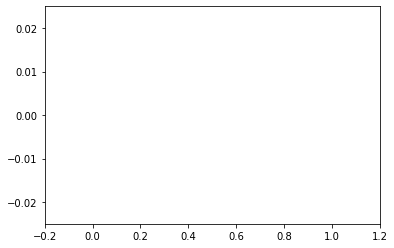

In [74]:
dx = 0.1
sol, x, t = hyperbolic_wraper(dx, 0.1)

anim = run_animation(dx, x, sol)
plt.show()


### 2. Solve the equation up to time $t=100$ with different time-steps $\Delta t$ bigger, equal and smaller than the $\Delta x$. Explain the results.

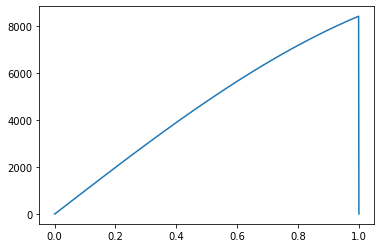

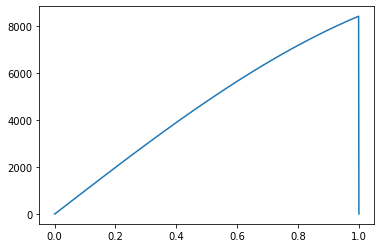

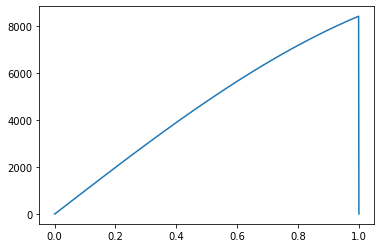

In [76]:
dt = 0.01
dx = 0.001

for _ in range(3):    
    sol, x, t = hyperbolic_wraper(dx, 0.1)
    plt.plot(x, sol[:, -1])
    dt /= 10
    plt.show()


